In [1]:
import pandas as pd
import numpy as np

# Load data input into df
df = pd.read_csv('sales_top10_skus.csv')

# Melt to long format: t, Year, Month stay as id_vars, others are SKUs
id_vars = ['t', 'Year', 'Month']
sku_columns = [col for col in df.columns if col not in id_vars]
df_long = df.melt(id_vars=id_vars, var_name='SKU', value_name='Sales')


In [2]:
# Add a truncated 'date' column

month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df_long['Month_num'] = df_long['Month'].map(month_map)
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month_num'].astype(str) + '-01')


# Show the first 5 rows
df_long.head()

,t,Year,Month,SKU,Sales,Month_num,Date
0,1,2021,January,6HSD4J,811306.11,1,2021-01-01
1,2,2021,February,6HSD4J,660086.35,2,2021-02-01
2,3,2021,March,6HSD4J,849879.16,3,2021-03-01
3,4,2021,April,6HSD4J,1379693.06,4,2021-04-01
4,5,2021,May,6HSD4J,759690.80,5,2021-05-01


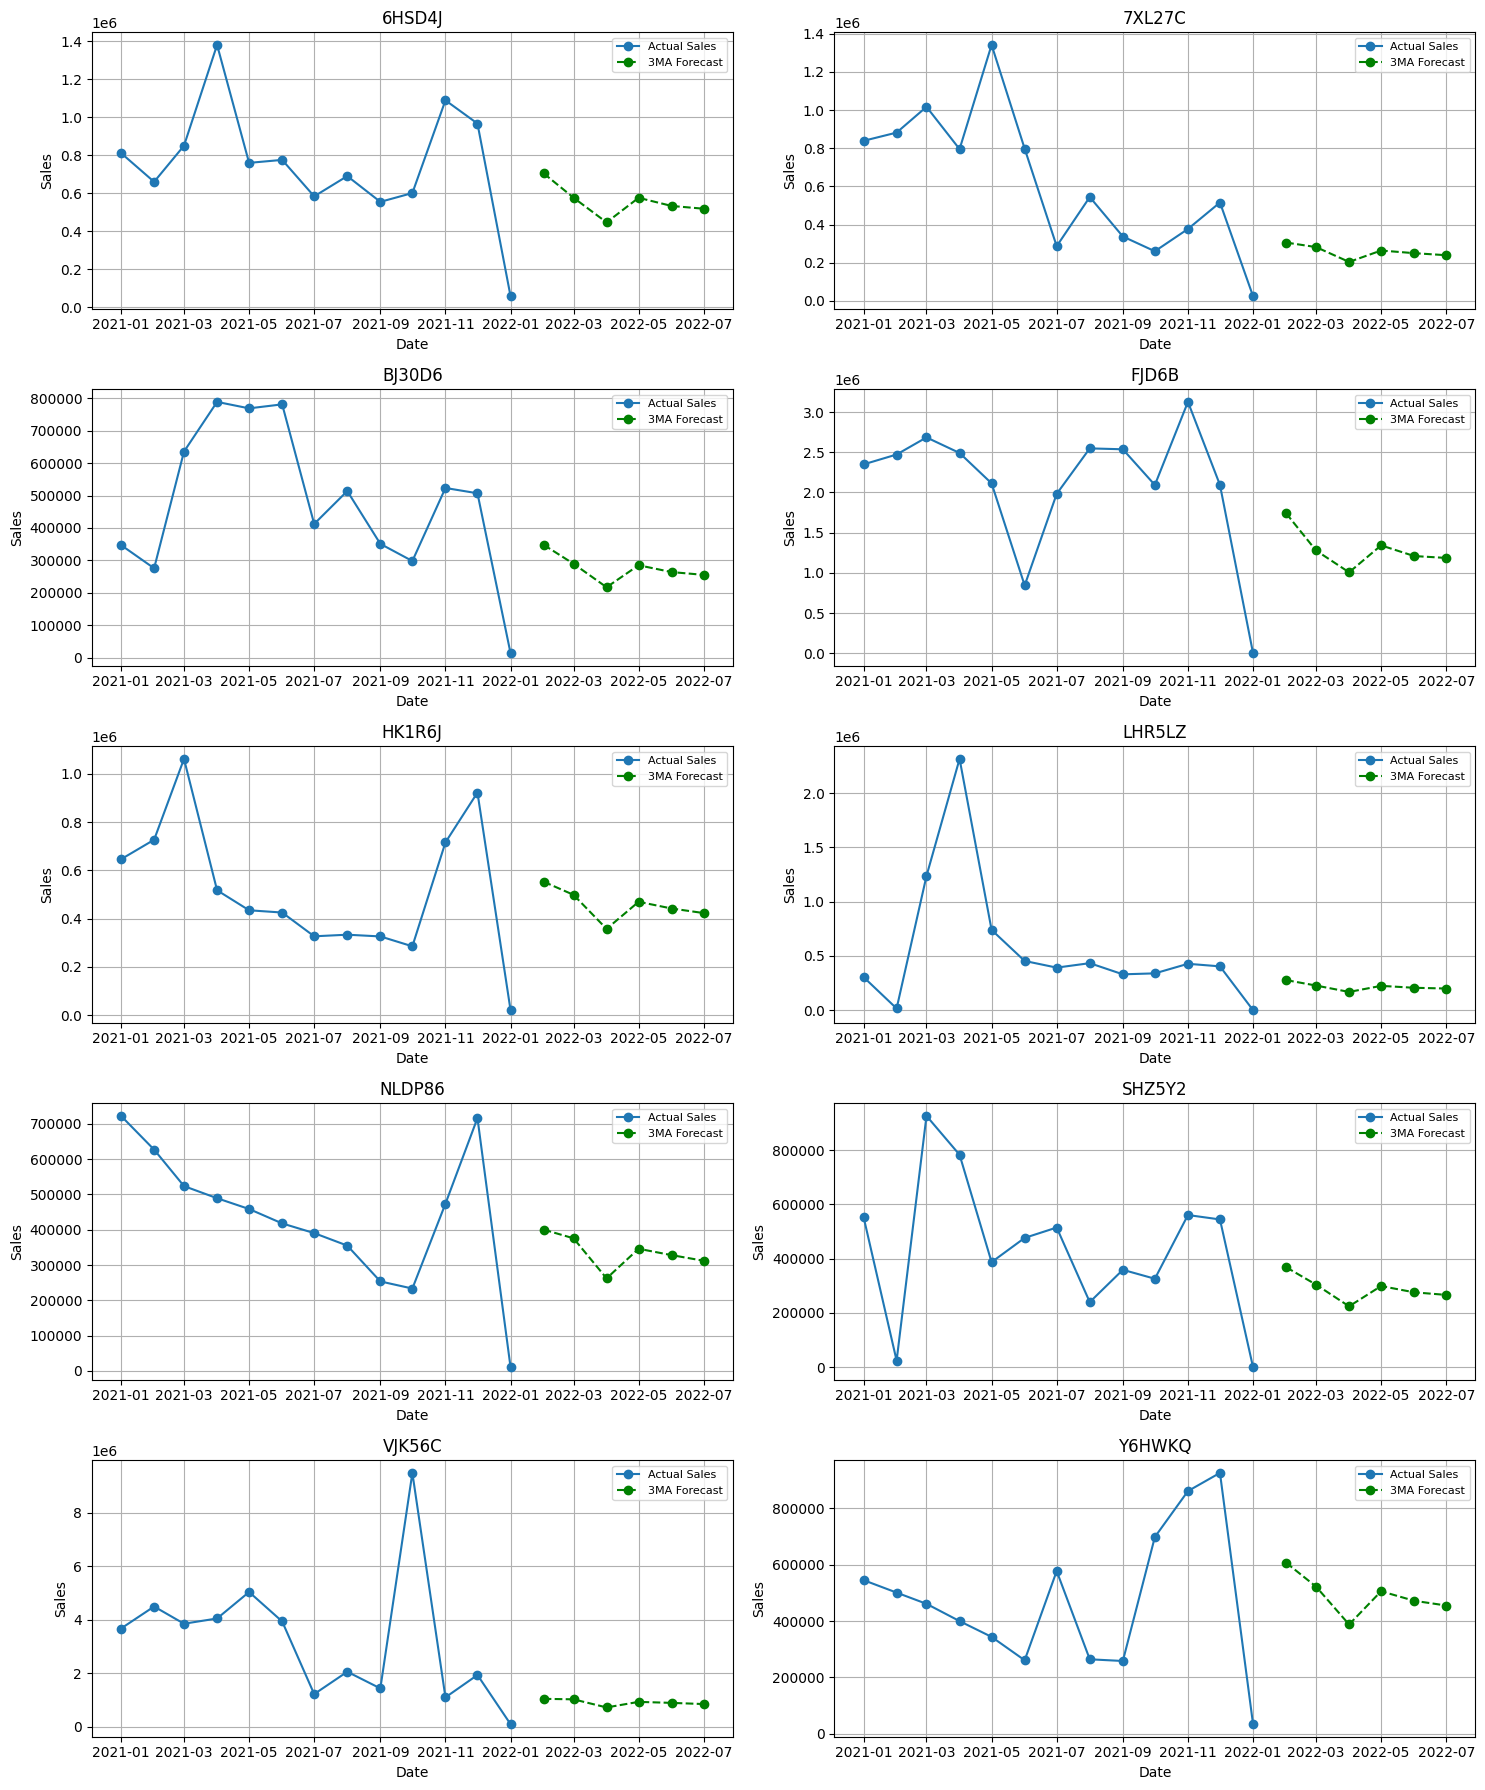

In [4]:
# Method 2: Three-month Moving Average
import matplotlib.pyplot as plt

# Prepare to collect everything for plotting
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
axes = axes.flatten()

results = []
sku_list = df_long['SKU'].unique()

for idx, sku in enumerate(sku_list):
    ax = axes[idx]
    sku_data = df_long[df_long['SKU'] == sku].sort_values('Date')
    y = sku_data['Sales'].values

    if pd.isnull(y).all() or (y == 0).all() or len(y) < 3:
        continue

    last_date = sku_data['Date'].max()
    forecast_vals = []
    recent = list(y[-3:])  # last 3 actuals

    # Forecast next 6 months using rolling 3MA
    for step in range(6):
        next_forecast = sum(recent[-3:]) / 3
        forecast_vals.append(next_forecast)
        recent.append(next_forecast)

    forecast_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    
    # Store forecasts in results
    for d, val in zip(forecast_dates, forecast_vals):
        results.append({'SKU': sku, 'Forecast_Month': d.strftime('%Y-%m'), 'Forecasted_Sales': val})

    # Plot actual
    ax.plot(sku_data['Date'], y, marker='o', label='Actual Sales')
    # Plot forecast
    ax.plot(forecast_dates, forecast_vals, 'g--o', label='3MA Forecast')
    ax.set_title(f'{sku}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend(fontsize=8)
    ax.grid(True)

# Hide unused subplots if < 10 SKUs
for i in range(len(sku_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



In [6]:
# Save to DataFrame
forecast_df = pd.DataFrame(results)
print(forecast_df.head())

# Optionally save to CSV
# forecast_ma_df.to_csv('forecast_3MA_next6m.csv', index=False)

      SKU Forecast_Month  Forecasted_Sales
0  6HSD4J        2022-02     704638.750000
1  6HSD4J        2022-03     576718.083333
2  6HSD4J        2022-04     446847.161111
3  6HSD4J        2022-05     576067.998148
4  6HSD4J        2022-06     533211.080864


In [7]:
# Save output to csv file (long format for further analysis)
forecast_df.to_csv("forecast_next6m_long.csv", index=False)

In [8]:
# Optionally: Convert forecast_next6m.csv to wide format for easier read

# Pivot to wide format: each SKU as a column, rows are Forecast_Month
wide_df = forecast_df.pivot(index='Forecast_Month', columns='SKU', values='Forecasted_Sales').reset_index()

# To display in notebook without index
from IPython.display import display
display(wide_df.style.hide(axis='index')) 

# Save to CSV
wide_df.to_csv('forecast_next6m_wide.csv', index=False)

Forecast_Month,6HSD4J,7XL27C,BJ30D6,FJD6B,HK1R6J,LHR5LZ,NLDP86,SHZ5Y2,VJK56C,Y6HWKQ
2022-02,704638.750000,305783.460000,348151.330000,1740273.086667,553178.776667,277137.336667,400234.440000,368418.103333,1039390.216667,607379.633333
2022-03,576718.083333,282084.230000,289739.630000,1278477.962222,498829.085556,227002.892222,375748.896667,304311.671111,1021091.545556,522619.861111
2022-04,446847.161111,204284.256667,217292.376667,1006900.499630,357453.127407,168046.742963,262268.655556,224243.258148,717434.464074,388098.281481
2022-05,576067.998148,264050.648889,285061.112222,1341883.849506,469820.329877,224062.323951,346083.997407,298991.010864,925972.075432,506032.591975
2022-06,533211.080864,250139.711852,264031.039630,1209087.437119,442034.180947,206370.653045,328033.849877,275848.646708,888166.028354,472250.244856
2022-07,518708.746708,239491.539136,255461.509506,1185957.262085,423102.546077,199493.239986,312128.834280,266360.971907,843857.522620,455460.372771
